# Numerical Differentiation for different dimensions

This iPython Notebook showcases how to compute derivatives of discrete signals, i.e. functions which are only known on a discrete set of points.

Since we don't have an analytical expression of the function we cannot use automatic differentiation (unless, we had fitted the function to a spline or something similar, but this is **not** the strategy taken in this project).

I've implemented a function called `grad` which calculates the gradient of any function $f : \mathbb{R}^n \to \mathbb{R}^m$ using finite differences.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 1D Differentiation
def diff(f, x):
    '''Returns three-point estimate (central difference) of derivative of f with respect to x'''
    f_pad = np.hstack([ 3*(f[0] - f[1]) + f[2],
                        f,
                        3*(f[-1] - f[-2]) + f[-3]])
    df = np.diff(f_pad)
    h = np.diff(x[:2])[0]
    return (df[1:] + df[:-1])/(2*h)

# # Alternative implementation
# # def diff(f,x):
# #     df = np.diff(f)
# #     h = np.diff(x[:2])[0]
# #     dfdx_l = (-3*f[0] + 4*f[1] - f[2])/(2*h)
# #     dfdx_c = (df[1:] + df[:-1])/(2*h)
# #     dfdx_r = (f[-3] - 4*f[-2] + 3*f[-1])/(2*h)
# #     return np.hstack([dfdx_l, dfdx_c, dfdx_r])

In [148]:
set([1, 2]) <= set([1, 2])

True

In [167]:
'''
This file contains a function, `grad`, which allow us to
differentiate any function defined on a grid through
finite differences. Note, the `grad` function allows for arbitrary
dimensions in the input and output, i.e. f : R^n -> R^m.
'''
import numpy as np

def _dtake(a, index, axis):
    '''numpy take a single index but keep dimensions.'''
    dims = [1 if i == axis else s for i, s in enumerate(a.shape)]
    return np.take(a=a, indices=index, axis=axis).reshape(dims)
    
def _take_many(f, indeces, axis):
    return (*[_dtake(f, i, axis) for i in indeces], )

def pad_left(f, axis):
    ''' makes left padding for calculating three-point
    difference estimate for the beginning point.
    '''
    f0, f1, f2 = _take_many(f, [0, 1, 2], axis)
    f_pad = np.concatenate([3*(f0 - f1) + f2, f], axis=axis)
    return f_pad

def pad_right(f, axis):
    ''' makes right padding for calculating three-point
    difference estimate for the end point.
    '''
    fm1, fm2, fm3 = _take_many(f, [-1, -2, -3], axis)
    f_pad = np.concatenate([f, 3*(fm1 - fm2) + fm3], axis=axis)
    return f_pad

def grad(f, *args, axes=None, cropped_axes=[]):
    '''
    Returns finite difference derivative of N-D array, f, with respect to arguments, *args.

    **Example:**
    Say we have a function, f : R^2 -> R^2 of
    two variables returning 2 values.
    I.e. f(x1, x2) = (f1(x1, x2), f2(x1, x2)).
    The function is defined on a grid of two
    input arrays with shapes x1 ~ (n1, ), x2 ~ (n2, )
    and therefore f has shape f ~ (n1, n2, 2).
    (The grid can be made through `X1, X2 = np.meshgrid(x1, x2, indexing='ij')` )
    
    Using `grad(f, x1, x2)` returns an array of shape ~ (n1, n2, 2, 2)
    containing the estimated partial derivatives
    of f1 and f2 with respect to x1 and x2.
    Thus, `grad(f, x1, x2)[:, :, 0, 0]` corresponds to ∂f_1/∂x_1
    and `grad(f, x1, x2)[:, :, 0, 1]` corresponds to ∂f_1/∂x_2.

    You may also use `grad(f, x2, axes=[1])`
    to only get ∂f_1/∂x_2 and ∂f_2/∂x_2 ... and so on.
    '''
    _f = f.squeeze()
    if axes is None:
        axes = np.arange(len(args))
    
    assert set(cropped_axes) <= set(axes), 'Error: Axes to crop must be contained in axes to differentiate along. Received `cropped_axes` = ' + str(cropped_axes) + ', but `axes` = ' + str(axes)
    shape = (s - 2 if i in cropped_axes else s for i, s in enumerate(_f.shape))
    grad_f = np.zeros((*shape, len(args)), dtype=_f.dtype)
    
    for i, (axis, xi) in enumerate(zip(axes, args)):
        # Handle edge cases
        if len(xi) == 1:
            # If we only have 1 point, assume function is constant.
            grad_f[..., i] = 0
            continue
        
        h = np.diff(xi[:2])[0]
        if h == 0:
            # If h is close to 0, set gradient to 0
            grad_f[..., i] = 0
            continue
        
        if len(xi) == 2:
            # If we only have 2 points use two-point difference
            df = np.diff(f, axis=axis)
            grad_f[..., i] = df/h
            continue
        
        # Main case
        if axis not in cropped_axes:
            # make padding for calculating three-point difference
            # estimate for the beginning and end points.
            f_pad = pad_right(pad_left(f, axis=axis), axis=axis)
        else:
            f_pad = f
        slice_pad = np.s_[[slice(1, -1) if (j != axis and j in cropped_axes) else slice(None) for j in range(len(f.shape))]]
        f_pad = f_pad[(*slice_pad, )]
        
        # The derivative is then calculated
        # as the central difference for all points.
        df_pad = np.diff(f_pad, axis=axis)
        grad_f_i = (np.take(df_pad, np.arange(1, df_pad.shape[axis]), axis=axis)
         + np.take(df_pad, np.arange(0, df_pad.shape[axis] - 1), axis=axis))/(2*h)
        grad_f[..., i] = grad_f_i

    return grad_f.squeeze()

## Examples

### $f : \mathbb{R} \to \mathbb{R}$

Consider:
$$
f(x) = \sin(a x) \\
f'(x) = a \cos(a x) \\
f''(x) = - a^2 \sin(ax)
$$

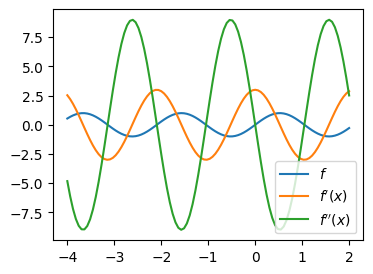

In [168]:
a = 3
x = np.linspace(-4, 2, 100)
f = np.sin(a*x)
_df = a*np.cos(a*x)
_ddf = -a**2 * np.sin(a*x)
plt.figure(figsize=(4,3))
plt.plot(x, f, label=r"$f$")
plt.plot(x, _df, label=r"$f'(x)$")
plt.plot(x, _ddf, label=r"$f''(x)$")
plt.legend()
plt.show()

Check that 1D function `diff` and general function `grad` agree:

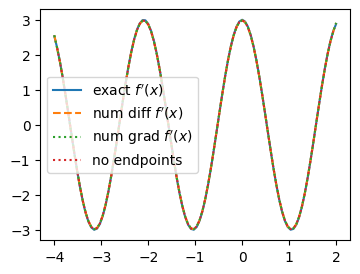

In [169]:
df = diff(f, x)
plt.figure(figsize=(4,3))
plt.plot(x, _df, label=r"exact $f'(x)$")
plt.plot(x, df, '--', label=r"num diff $f'(x)$")
plt.plot(x, grad(f, x), ':', label=r"num grad $f'(x)$")
plt.plot(x[1:-1], grad(f, x, cropped_axes=[0]), ':', label=r"no endpoints")
plt.legend()
plt.show()

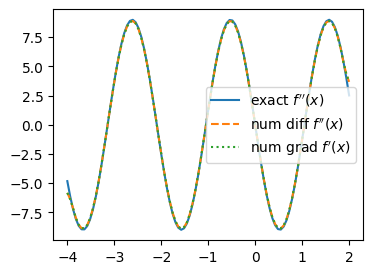

In [170]:
ddf = diff(diff(f, x),x)
plt.figure(figsize=(4,3))
plt.plot(x, _ddf, label=r"exact $f''(x)$")
plt.plot(x, ddf, '--', label=r"num diff $f''(x)$")
plt.plot(x, grad(grad(f, x), x), ':', label=r"num grad $f'(x)$")
plt.legend()
plt.show()

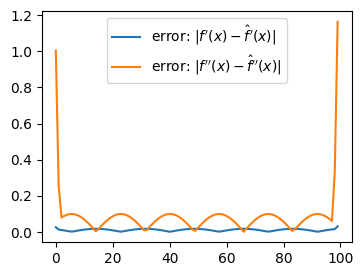

In [171]:
plt.figure(figsize=(4,3))
plt.plot(np.abs(_df - df), label="error: $|f'(x) - \hat{f}'(x)|$")
plt.plot(np.abs(_ddf - ddf), label="error: $|f''(x) - \hat{f}''(x)|$")
plt.legend()
plt.show()

### $f : \mathbb{R}^2 \to \mathbb{R}$

Consider:
$$
f(x_1, x_2) = x_1 \sin(a x_2) \\[1em]

\partial_{x} f = 
\nabla f =
\left(
\begin{array}{c}
    \partial_{x_1} f \\
    \partial_{x_2} f
\end{array}
\right)
=
\left(
\begin{array}{c}
    \sin(a x_2) \\
    a x_1 \cos(a x_2)
\end{array}
\right)
$$

In [172]:
a=3
_f = lambda x1, x2 : x1 * np.sin(a*x2)
_df = lambda x1, x2 : np.stack((np.sin(a*x2),
                                 a * x1 * np.cos(a*x2)), axis=-1)

x1 = np.linspace(-1, 1, 1000)
x2 = np.linspace(0, 2/a*np.pi, 2000)
X1, X2 = np.meshgrid(x1, x2, indexing='ij')
f = _f(X1, X2)

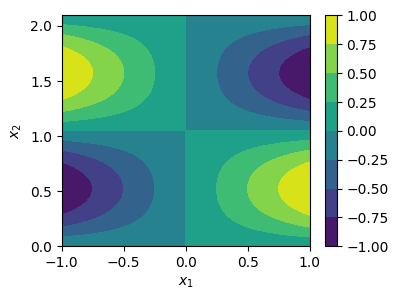

In [173]:
plt.figure(figsize=(4,3))
plt.contourf(X1, X2, f)
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

In [174]:
# How to calculate the derivative without using the grad function
# I use this to assert that the grad function gives the expected result
n1, n2 = f.shape
df = np.zeros((n1, n2, 2))
for i in range(n1):
    df[i, :, 1] = diff(f[i, :], x2)
for j in range(n2):
    df[:, j, 0] = diff(f[:, j], x1)

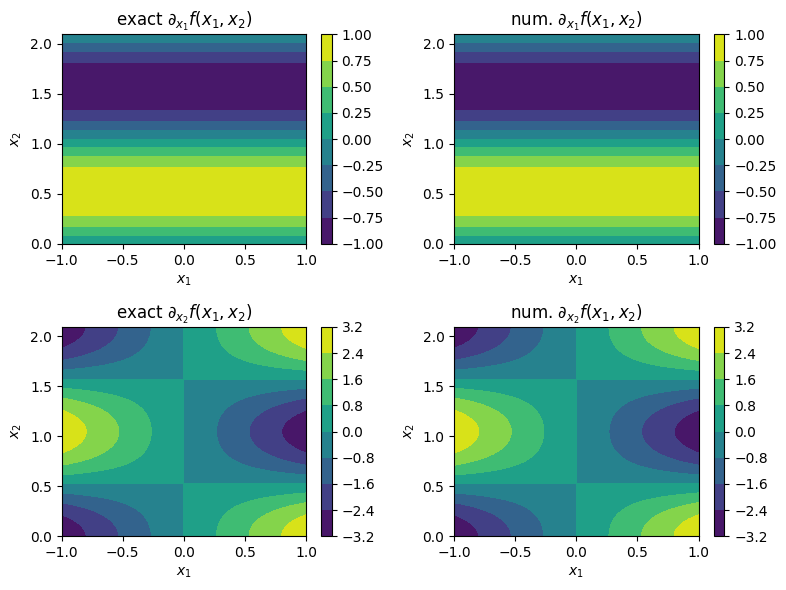

In [175]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
cont = ax[0,0].contourf(X1, X2, _df(X1, X2)[:, :, 0])
plt.colorbar(cont)
ax[0, 0].set_xlabel(r'$x_1$')
ax[0, 0].set_ylabel(r'$x_2$')
ax[0, 0].set_title(r'exact $\partial_{x_1} f(x_1, x_2)$')

cont = ax[0,1].contourf(X1, X2, df[:, :, 0])
plt.colorbar(cont)
ax[0, 1].set_xlabel(r'$x_1$')
ax[0, 1].set_ylabel(r'$x_2$')
ax[0, 1].set_title(r'num. $\partial_{x_1} f(x_1, x_2)$')

cont = ax[1, 0].contourf(X1, X2, _df(X1, X2)[:, :, 1])
plt.colorbar(cont)
ax[1,0].set_xlabel(r'$x_1$')
ax[1,0].set_ylabel(r'$x_2$')
ax[1,0].set_title(r'exact $\partial_{x_2} f(x_1, x_2)$')

cont = ax[1,1].contourf(X1, X2, df[:, :, 1])
plt.colorbar(cont)
ax[1,1].set_xlabel(r'$x_1$')
ax[1,1].set_ylabel(r'$x_2$')
ax[1,1].set_title(r'num. $\partial_{x_2} f(x_1, x_2)$')

plt.tight_layout()
plt.show()

In [176]:
print('max abs. error: ', np.max(np.abs(_df(X1, X2) - df)))

max abs. error:  9.879447250948914e-06


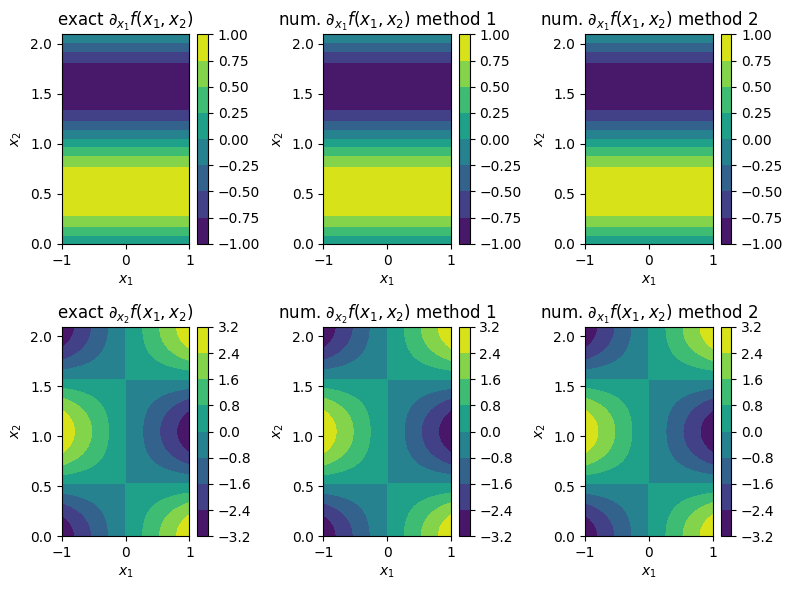

In [177]:
fig, ax = plt.subplots(2, 3, figsize=(8, 6))
cont = ax[0,0].contourf(X1, X2, _df(X1, X2)[:, :, 0])
plt.colorbar(cont)
ax[0, 0].set_xlabel(r'$x_1$')
ax[0, 0].set_ylabel(r'$x_2$')
ax[0, 0].set_title(r'exact $\partial_{x_1} f(x_1, x_2)$')

cont = ax[0,1].contourf(X1, X2, grad(f, x1, axes=[0]))
plt.colorbar(cont)
ax[0, 1].set_xlabel(r'$x_1$')
ax[0, 1].set_ylabel(r'$x_2$')
ax[0, 1].set_title(r'num. $\partial_{x_1} f(x_1, x_2)$ method 1')

cont = ax[0, 2].contourf(X1, X2, grad(f, x1, x2)[:, :, 0])
plt.colorbar(cont)
ax[0, 2].set_xlabel(r'$x_1$')
ax[0, 2].set_ylabel(r'$x_2$')
ax[0, 2].set_title(r'num. $\partial_{x_1} f(x_1, x_2)$ method 2')

cont = ax[1, 0].contourf(X1, X2, _df(X1, X2)[:, :, 1])
plt.colorbar(cont)
ax[1,0].set_xlabel(r'$x_1$')
ax[1,0].set_ylabel(r'$x_2$')
ax[1,0].set_title(r'exact $\partial_{x_2} f(x_1, x_2)$')

cont = ax[1,1].contourf(X1, X2, grad(f, x2, axes=[1]))
plt.colorbar(cont)
ax[1,1].set_xlabel(r'$x_1$')
ax[1,1].set_ylabel(r'$x_2$')
ax[1,1].set_title(r'num. $\partial_{x_2} f(x_1, x_2)$ method 1')

cont = ax[1, 2].contourf(X1, X2, grad(f, x1, x2)[:, :, 1])
plt.colorbar(cont)
ax[1, 2].set_xlabel(r'$x_1$')
ax[1, 2].set_ylabel(r'$x_2$')
ax[1, 2].set_title(r'num. $\partial_{x_1} f(x_1, x_2)$ method 2')

plt.tight_layout()
plt.show()

In [179]:
# Test with endpoint exclusion
grad(f, x1, x2, cropped_axes=[0, 1]).shape, grad(f, x1, x2, cropped_axes=[1]).shape, grad(f, x2, axes=[1], cropped_axes=[1]).shape, grad(f, x1, axes=[0], cropped_axes=[0]).shape

((998, 1998, 2), (1000, 1998, 2), (1000, 1998), (998, 2000))

#### Hessian

Consider next the second derivative (Hessian):
$$
f(x_1, x_2) = x_1 \sin(a x_2) \\[1em]

\partial_{x} f = 
\nabla f =
\left(
\begin{array}{c}
    \partial_{x_1} f \\
    \partial_{x_2} f
\end{array}
\right)
=
\left(
\begin{array}{c}
    \sin(a x_2) \\
    a x_1 \cos(a x_2)
\end{array}
\right)
$$

**Note:** $\nabla f : \mathbb{R}^2 \to \mathbb{R}^2$ so $\nabla \nabla f : \mathbb{R}^2 \to \mathbb{R}^{2 \times 2}$

$$
\\[1em]

\partial_{x}^2 f = \nabla \nabla f = 
\left(
\begin{array}{c}
    \partial_{x_1}^2 f  & \partial_{x_1} \partial_{x_2} f \\
    \partial_{x_2} \partial_{x_1} f & \partial_{x_2}^2 f
\end{array}
\right)
= 
\left(
\begin{array}{c}
    0
    &
    a \cos(a x_2)
    \\
    a \cos(a x_2)
    &
    - a^2 x_1 \sin(a x_2)
\end{array}
\right)
$$

In [14]:
_ddf = lambda x1, x2: np.stack([
    np.stack([np.zeros(x1.shape), a*np.cos(a*x2)], axis=2),
    np.stack([a*np.cos(a*x2), -a**2 * x1 * np.sin(a*x2)], axis=2)
    ], axis=3)
ddf = grad(grad(f, x1, x2), x1, x2)

In [15]:
print(
    'Test that all first entries in Hessian are zero:\n',
    'Are they zero for the finite difference estimate? ',
    np.all(np.isclose(ddf[:, :, 0, 0], 0)),
    '\n Are the zero for the exact function? ',
    np.all(np.isclose(_ddf(X1, X2)[:, :, 0, 0], 0))
)
print('maximal error for all values: ', np.max(np.abs(ddf - _ddf(X1, X2))))

Test that all first entries in Hessian are zero:
 Are they zero for the finite difference estimate?  True 
 Are the zero for the exact function?  True
maximal error for all values:  0.021216376463963703


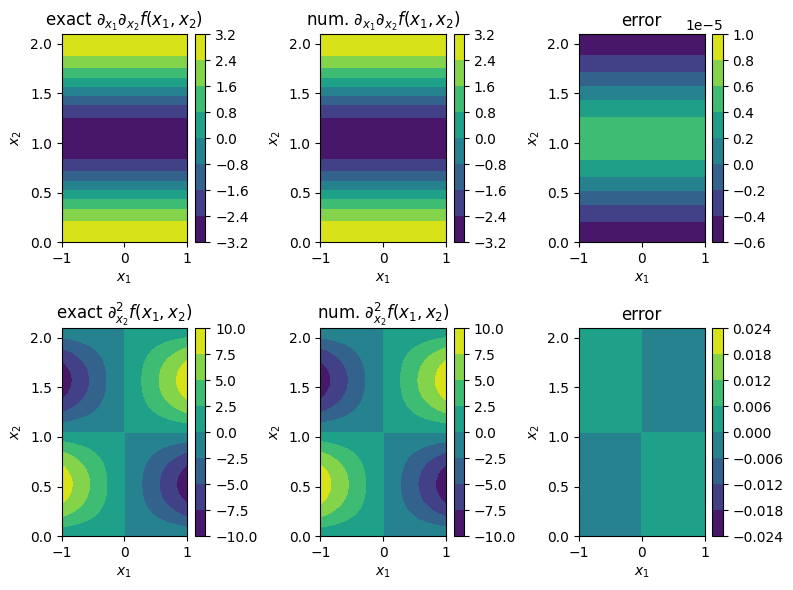

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(8, 6))
cont = ax[0,0].contourf(X1, X2, _ddf(X1, X2)[:, :, 0, 1])
plt.colorbar(cont)
ax[0, 0].set_xlabel(r'$x_1$')
ax[0, 0].set_ylabel(r'$x_2$')
ax[0, 0].set_title(r'exact $\partial_{x_1} \partial_{x_2} f(x_1, x_2)$')

cont = ax[0,1].contourf(X1, X2, ddf[:, :, 0, 1])
plt.colorbar(cont)
ax[0, 1].set_xlabel(r'$x_1$')
ax[0, 1].set_ylabel(r'$x_2$')
ax[0, 1].set_title(r'num. $\partial_{x_1} \partial_{x_2} f(x_1, x_2)$')

cont = ax[0,2].contourf(X1, X2, ddf[:, :, 0, 1] - _ddf(X1, X2)[:, :, 0, 1])
plt.colorbar(cont)
ax[0, 2].set_xlabel(r'$x_1$')
ax[0, 2].set_ylabel(r'$x_2$')
ax[0, 2].set_title(r'error')

cont = ax[1,0].contourf(X1, X2, _ddf(X1, X2)[:, :, 1, 1])
plt.colorbar(cont)
ax[1, 0].set_xlabel(r'$x_1$')
ax[1, 0].set_ylabel(r'$x_2$')
ax[1, 0].set_title(r'exact $\partial_{x_2}^2 f(x_1, x_2)$')

cont = ax[1,1].contourf(X1, X2, ddf[:, :, 1, 1])
plt.colorbar(cont)
ax[1, 1].set_xlabel(r'$x_1$')
ax[1, 1].set_ylabel(r'$x_2$')
ax[1, 1].set_title(r'num. $\partial_{x_2}^2 f(x_1, x_2)$')

cont = ax[1,2].contourf(X1, X2, ddf[:, :, 1, 1] - _ddf(X1, X2)[:, :, 1, 1])
plt.colorbar(cont)
ax[1, 2].set_xlabel(r'$x_1$')
ax[1, 2].set_ylabel(r'$x_2$')
ax[1, 2].set_title(r'error')

plt.tight_layout()
plt.show()

If we only wish to calculate the partial derivative of the gradient w.r.t. $x_2$, i.e. $(\partial_{x_2}\partial_{x_1} f, \,\, \partial_{x_2}^2 f)$, we can do:

In [17]:
dx2gradf = grad(grad(f, x1, x2), x2, axes=[1])
# Compare with exact value
print(
    'max error: ',
    np.max(np.abs(dx2gradf - _ddf(X1, X2)[:, :, 1, :]))
)

max error:  0.021216376463963703


### $f: \mathbb{R}^3 \to \mathbb{R}$

Consider:
$$
f(x_1, x_2) = x_1 \sin(a x_2) + x_2 x_3 \\[1em]

\partial_{x} f = 
\nabla f =
\left(
\begin{array}{c}
    \partial_{x_1} f \\
    \partial_{x_2} f \\
    \partial_{x_3} f
\end{array}
\right)
=
\left(
\begin{array}{c}
    \sin(a x_2) \\
    a x_1 \cos(a x_2) + x_3 \\
    x_2
\end{array}
\right)
$$

In [18]:
a=3
_f = lambda x1, x2, x3 : x1 * np.sin(a*x2) + x2 * x3
_df = lambda x1, x2, x3 : np.stack((np.sin(a*x2),
                                 a * x1 * np.cos(a*x2) + x3, x2), axis=-1)

x1 = np.linspace(-1, 1, 100)
x2 = np.linspace(0, 2/a*np.pi, 200)
x3 = np.linspace(0, 10, 300)
X1, X2, X3 = np.meshgrid(x1, x2, x3, indexing='ij')
f = _f(X1, X2, X3)

To plot the results for a 3D input, we need to make some (arbitrary) intersections, where we keep one coordinate constant:

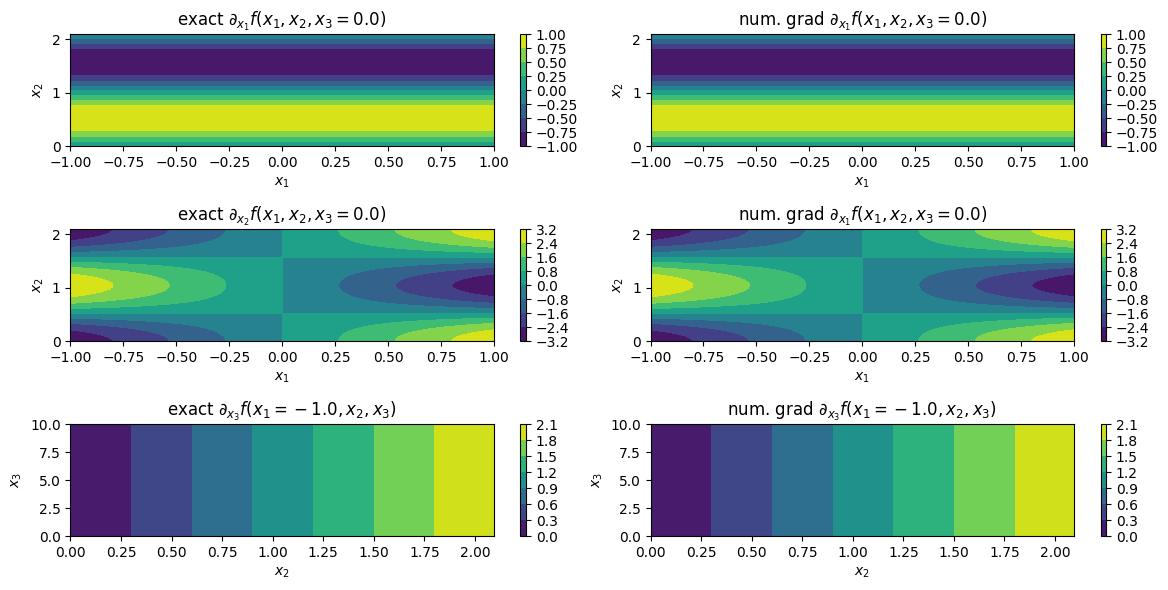

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(12, 6))
cont = ax[0,0].contourf(X1[..., 0], X2[..., 0], _df(X1[..., 0], X2[..., 0], X3[..., 0])[:, :, 0])
plt.colorbar(cont)
ax[0, 0].set_xlabel(r'$x_1$')
ax[0, 0].set_ylabel(r'$x_2$')
ax[0, 0].set_title(r'exact $\partial_{x_1} f(x_1, x_2, x_3 = ' + str(x3[0]) + ')$')

cont = ax[0,1].contourf(X1[..., 0], X2[..., 0], grad(f, x1, x2, x3)[..., 0, 0])
plt.colorbar(cont)
ax[0, 1].set_xlabel(r'$x_1$')
ax[0, 1].set_ylabel(r'$x_2$')
ax[0, 1].set_title(r'num. grad $\partial_{x_1} f(x_1, x_2, x_3 = ' + str(x3[0]) + ')$')

cont = ax[1, 0].contourf(X1[..., 0], X2[..., 0], _df(X1[..., 0], X2[..., 0], X3[..., 0])[:, :, 1])
plt.colorbar(cont)
ax[1, 0].set_xlabel(r'$x_1$')
ax[1, 0].set_ylabel(r'$x_2$')
ax[1, 0].set_title(r'exact $\partial_{x_2} f(x_1, x_2, x_3 = ' + str(x3[0]) + ')$')

cont = ax[1, 1].contourf(X1[..., 0], X2[..., 0], grad(f, x1, x2, x3)[..., 0, 1])
plt.colorbar(cont)
ax[1, 1].set_xlabel(r'$x_1$')
ax[1, 1].set_ylabel(r'$x_2$')
ax[1, 1].set_title(r'num. grad $\partial_{x_1} f(x_1, x_2, x_3 = ' + str(x3[0]) + ')$')

cont = ax[2, 0].contourf(X2[0, ...], X3[0, ...], _df(X1[0, ...], X2[0, ...], X3[0, ...])[:, :, 2])
plt.colorbar(cont)
ax[2, 0].set_xlabel(r'$x_2$')
ax[2, 0].set_ylabel(r'$x_3$')
ax[2, 0].set_title(r'exact $\partial_{x_3} f(x_1 = ' + str(x1[0]) + ', x_2, x_3)$')

cont = ax[2, 1].contourf(X2[0, ...], X3[0, ...], grad(f, x1, x2, x3)[0, ..., 2])
plt.colorbar(cont)
ax[2, 1].set_xlabel(r'$x_2$')
ax[2, 1].set_ylabel(r'$x_3$')
ax[2, 1].set_title(r'num. grad $\partial_{x_3} f(x_1 = ' + str(x1[0]) + ', x_2, x_3)$')

plt.tight_layout()
plt.show()

### $f: \mathbb{R}^2 \to \mathbb{R}^2$

See example above, where we calculate the Hessian for $f : \mathbb{R}^2 \to \mathbb{R}$. (there $\nabla f : \mathbb{R}^2 \to \mathbb{R}^2$ so $\nabla \nabla f : \mathbb{R}^2 \to \mathbb{R}^{2 \times 2}$)

### Edge cases:

#### Only 1 datapoint (Assume constant function)

In [20]:
a = 3
x = np.linspace(-4, 2, 1)
f = np.sin(a*x)
grad(f, x)

array(0.)

#### Only 2 datapoints (two point difference)

In [21]:
a = 3
x = np.linspace(-4, 2, 2)
f = np.sin(a*x)
grad(f, x)

array([-0.13599807, -0.13599807])

In [22]:
a=3
_f = lambda x1, x2 : x1 * np.sin(a*x2)
_df = lambda x1, x2 : np.stack((np.sin(a*x2),
                                 a * x1 * np.cos(a*x2)), axis=-1)

x1 = np.linspace(-1, 1, 2)
x2 = np.linspace(0, 2/(4*a)*np.pi, 10)
X1, X2 = np.meshgrid(x1, x2, indexing='ij')
f = _f(X1, X2)

In [23]:
# Since the function is linear, in the x1 direction,
# two datapoints is actually sufficient for
# calculating the gradient.
grad(f, x1, axes=[0]) == np.sin(a*x2) 

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])

### Same x-values for array

In [27]:
a = 3
x = np.array([2, 2, 2])
f = np.sin(a*x)
grad(f, x)

array([0., 0., 0.])

In [28]:
f

array([-0.2794155, -0.2794155, -0.2794155])